In [2]:
%matplotlib inline 
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72'
)


In [3]:
# 读取香蕉检测数据集
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_iter = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(
        data_iter,
        'bananas_train' if is_train else 'bananas_val',
        'label.csv'
    )
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(
            torchvision.io.read_image(
                os.path.join(
                    data_iter,
                    'bananas_train' if is_train else 'bananas_val',
                    'images', 
                    f'{img_name}'
                )
            )
        )
        # 此处target包括 (类别, 左上x, 左上y,
        # 右下 x, 右下 y), 所有图片都有一样的
        # 香蕉类 (index 0)
        targets.append(list(target))
    # 边缘框存储的时候是按比例来的。所以要/256
    return images, torch.tensor(targets).unsqueeze(1) / 256


In [4]:
# 创建一个自定义 Dateset 实例
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""

    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print(
            'read ' + str(len(self.features)) + 
            (f' training examples' if is_train else f' validation examples')
        )

    # 读取第 idx 个样本的具体过程
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    # 返回数据集有多长
    def __len__(self):
        return len(self.features)


In [5]:
# 为训练集和测试集返回两个数据加载器实例
"""
    用图片做批量的问题：不同图片会有不同的物体个数
    处理方式：
        假设设定最多一张图片有5个物体，
        如果多了就把图片丢掉
        少了添0
    （
        如果有5个label，五行，就丢掉这张图
        少了就加0
        这样就可以做成一个规整的Tensor
    ）
"""
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(
        BananasDataset(is_train=True),
        batch_size, 
        shuffle=True
    )
    val_iter = torch.utils.data.DataLoader(
        BananasDataset(is_train=False),
        batch_size
    )
    return train_iter, val_iter


In [6]:
# 读取一个小批量，并打印其中的图像和标签的形状
batch_size, edge_size = 32, 256 
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
"""
    batch[1]: (batch, 一张图片最多有几个物体, [标号 + 4个坐标])
"""
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

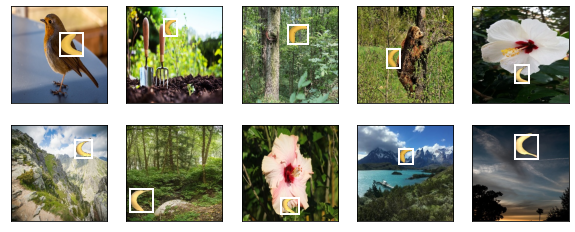

In [8]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])